# Meta-Learner Regime Prediction Model
**Prepared by:** Adisorn Promkaewngarm

# Import Library

In [ ]:
!pip -q install mplfinance

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.0/75.0 kB 2.4 MB/s eta 0:00:00


In [ ]:
!pip -q install xgboost

In [ ]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import time

from sklearn.preprocessing import StandardScaler

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
import mplfinance as mpf
import os
import random

# Import Data

In [ ]:
# GitHub Raw Data Paths
path_feature = 'https://raw.githubusercontent.com/adisorn242/2026_WQU_CapstoneProject/main/df_SET_features_weekly.csv'
path_label_train = 'https://raw.githubusercontent.com/adisorn242/2026_WQU_CapstoneProject/main/df_regime_labeling_traindata_weekly.csv'
path_set_data = 'https://raw.githubusercontent.com/adisorn242/2026_WQU_CapstoneProject/main/SET_Index_Weekly_2010_2025.csv'

# 1. Load the feature set
df_features = pd.read_csv(path_feature, index_col=0, parse_dates=True)

  # Train-Test split by period
df_features_train = df_features.loc[df_features.index.year < 2023].copy()
df_features_train = df_features_train.iloc[:, 1:] # Remove currnet return

  # Train-Test split by period
df_features_test = df_features.loc[df_features.index.year >= 2023,].copy()
df_features_test = df_features_test.iloc[:, 1:] # Remove currnet return

# 2. Load the training labels
df_labels = pd.read_csv(path_label_train, index_col=0, parse_dates=True)
df_labels_train = df_labels['Regime_ID'].copy()

# 3. Load the raw SET Index OHLC data
df_set_index = pd.read_csv(path_set_data, index_col=0, parse_dates=True)

In [ ]:
# 1. Check Training Set Alignment (Features vs. GM-HMM Labels)
train_indices_match = df_features_train.index.equals(df_labels_train.index)

# Define df_set_index_test here to resolve NameError
df_set_index_test = df_set_index.loc[df_set_index.index.year >= 2023].copy()

# 2. Check Testing Set Alignment (Features vs. Raw SET Index)
test_indices_match = df_features_test.index.equals(df_set_index_test.index)

# 3. Print Results
print("="*50)
print("INDEX CONSISTENCY VERIFICATION")
print("="*50)
print(f"Training Set Indices Match: {train_indices_match}")
print(f"Testing Set Indices Match:  {test_indices_match}")
print("-" * 50)

# If they don't match, let's see where the discrepancy is
if not train_indices_match:
    print(f"Training Features: {len(df_features_train)} rows")
    print(f"Training Labels:   {len(df_labels_train)} rows")
    # Finding the difference
    diff = df_features_train.index.difference(df_labels_train.index)
    print(f"Missing dates in labels: {len(diff)}")

if not test_indices_match:
    print(f"Testing Features:  {len(df_features_test)} rows")
    print(f"Testing SET Data:  {len(df_set_index_test)} rows")
print("="*50)

INDEX CONSISTENCY VERIFICATION
Training Set Indices Match: True
Testing Set Indices Match:  True
--------------------------------------------------


# Data Normalization

In [ ]:
# 1. Initialize the Scaler
scaler = StandardScaler()

# 2. Fit and Transform the Training Data
X_train_scaled = scaler.fit_transform(df_features_train)

# 3. Transform the Testing Data (using the training parameters)
X_test_scaled = scaler.transform(df_features_test)

# Convert back to DataFrame to maintain column names for XGBoost
X_train_final = pd.DataFrame(X_train_scaled, index=df_features_train.index, columns=df_features_train.columns)
X_test_final = pd.DataFrame(X_test_scaled, index=df_features_test.index, columns=df_features_test.columns)

# Model Training - Based Learners

In [ ]:
from sklearn.linear_model import LogisticRegression

# INITIALIZE AND TRAIN LOGISTIC REGRESSION
# Using your precise optimized parameters
final_lr_model = LogisticRegression(
    C=0.004832930238571752,
    penalty='l2',
    class_weight='balanced',
    solver='saga',
    multi_class='multinomial',
    random_state=42,
    max_iter=2000
)

# Fit the model
start_time_lr = time.time()
final_lr_model.fit(X_train_final, df_labels_train)
lr_train_duration = time.time() - start_time_lr

# METRICS CALCULATION
y_train_pred_lr = final_lr_model.predict(X_train_final)

lr_train_accuracy = accuracy_score(df_labels_train, y_train_pred_lr)
lr_train_f1 = f1_score(df_labels_train, y_train_pred_lr, average='weighted')

print(f"Logistic Regression fitted. (Time: {lr_train_duration:.2f}s)")

Logistic Regression fitted. (Time: 0.04s)


In [ ]:
import xgboost as xgb

# INITIALIZE AND TRAIN XGBOOST
xgb_model = xgb.XGBClassifier(
    n_estimators=250,
    learning_rate=0.03,
    max_depth=5,
    min_child_weight=5,
    gamma=0.,
    subsample=0.6,
    colsample_bytree=0.6,

    # Static Configuration
    objective='multi:softmax',
    num_class=3,
    random_state=42,
    eval_metric='mlogloss',
    tree_method='hist',
    device='cuda'
)

# Fit the model using the training data and labels
start_time_xgb = time.time()
xgb_model.fit(X_train_final, df_labels_train)
xgb_train_duration = time.time() - start_time_xgb

# METRICS CALCULATION
y_train_pred_xgb = xgb_model.predict(X_train_final)

xgb_train_accuracy = accuracy_score(df_labels_train, y_train_pred_xgb)
xgb_train_f1 = f1_score(df_labels_train, y_train_pred_xgb, average='weighted')

print(f"XGBoost training completed in {xgb_train_duration:.2f} seconds.")

XGBoost training completed in 7.07 seconds.


In [ ]:
from sklearn.svm import SVC

# INITIALIZE AND TRAIN SVM
svm_model = SVC(
    C=0.6173770394704572,
    cache_size=1000,
    class_weight='balanced',
    gamma='auto',
    shrinking=True,
    tol=0.001,
    kernel='rbf',
    probability=True,
    random_state=42
)

# Fit the model using the training data and labels
start_time_svm = time.time()
svm_model.fit(X_train_final, df_labels_train)
svm_train_duration = time.time() - start_time_svm

# METRICS CALCULATION
y_train_pred_svm = svm_model.predict(X_train_final)

svm_train_accuracy = accuracy_score(df_labels_train, y_train_pred_svm)
svm_train_f1 = f1_score(df_labels_train, y_train_pred_svm, average='weighted')

print(f"SVM training completed in {svm_train_duration:.2f} seconds.")

SVM training completed in 0.25 seconds.


In [ ]:
from sklearn.ensemble import RandomForestClassifier

# INITIALIZE AND TRAIN RANDOM FOREST
rf_model = RandomForestClassifier(
    n_estimators=634,
    min_samples_split=19,
    min_samples_leaf=2,
    max_features='log2',
    max_depth=None,
    criterion='gini',
    bootstrap=True,
    oob_score=True,
    random_state=42,
    n_jobs=-1
)

# Fit the model using the training data and labels
start_time_rf = time.time()
rf_model.fit(X_train_final, df_labels_train)
rf_train_duration = time.time() - start_time_rf

# METRICS CALCULATION
y_train_pred_rf = rf_model.predict(X_train_final)

rf_train_accuracy = accuracy_score(df_labels_train, y_train_pred_rf)
rf_train_f1 = f1_score(df_labels_train, y_train_pred_rf, average='weighted')

print(f"Random Forest training completed in {rf_train_duration:.2f} seconds.")

Random Forest training completed in 2.60 seconds.


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import os
import random

# 1. APPLY REPRODUCIBILITY SEEDS
os.environ['PYTHONHASHSEED'] = '0'
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

# Force deterministic operations for CPU execution
os.environ['TF_DETERMINISTIC_OPS'] = '1'
try:
    tf.config.experimental.enable_op_determinism()
except AttributeError:
    pass

# 2. INITIALIZE AND TRAIN DNN
dnn_model = keras.Sequential([
    keras.Input(shape=(X_train_final.shape[1],)),

    # Layer 1:
    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),

    # Layer 2:
    layers.Dense(8, activation='sigmoid'),
    layers.BatchNormalization(),
    layers.Dropout(0.),

    # Output: 3 Classes (Softmax)
    layers.Dense(3, activation='softmax')
])

# Compile with your optimized settings
dnn_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Fit the model
start_time_dnn = time.time()
dnn_model.fit(X_train_final, df_labels_train, epochs=50, batch_size=32, verbose=0)
dnn_train_duration = time.time() - start_time_dnn

# METRICS CALCULATION
y_train_prob_dnn = dnn_model.predict(X_train_final, verbose=0)
y_train_pred_dnn = np.argmax(y_train_prob_dnn, axis=1)

dnn_train_accuracy = accuracy_score(df_labels_train, y_train_pred_dnn)
dnn_train_f1 = f1_score(df_labels_train, y_train_pred_dnn, average='weighted')

print(f"DNN training completed in {dnn_train_duration:.2f} seconds.")

DNN training completed in 8.00 seconds.


# Stacking Meta-Learner

## Meta-Learner using Logistic Regression (Slightly Outperformed)

In [ ]:
from sklearn.linear_model import LogisticRegression

print("="*60)
print("PART 1: TRAINING THE STACKING META-LEARNER")
print("="*60)

# 1. GENERATE META-FEATURES (PROBABILITIES)

# Base Model 1: XGBoost
meta_xgb_train = xgb_model.predict_proba(X_train_final)

# Base Model 2: Logistic Regression (New Base Learner)
meta_lr_train = final_lr_model.predict_proba(X_train_final)

# Base Model 3: SVM
meta_svm_train = svm_model.predict_proba(X_train_final)

# Base Model 4: Random Forest
meta_rf_train = rf_model.predict_proba(X_train_final)

# Base Model 5: DNN
# Note: Keras 'predict' returns probabilities for softmax output
meta_dnn_train = dnn_model.predict(X_train_final, verbose=0)

# Concatenate all probabilities (3 probabilities per model * 5 models = 15 columns)
X_meta_train = np.hstack([
    meta_xgb_train,
    meta_lr_train,
    meta_svm_train,
    meta_rf_train,
    meta_dnn_train
])

# 2. TRAIN THE META-LEARNER-
# Initializing the Logistic Regression Meta-Learner
# This model learns which base-model probabilities are most reliable for each regime.
meta_learner = LogisticRegression(
    multi_class='multinomial',
    class_weight='balanced',  # Maintain sensitivity to Bull/Bear regimes
    random_state=42,
    max_iter=1000
)

# Training the meta-learner on the meta-features
start_time = time.time()
meta_learner.fit(X_meta_train, df_labels_train)
duration = time.time() - start_time

print(f"Meta-Learner training completed in {duration:.2f} seconds.")
print(f"Meta-feature matrix shape: {X_meta_train.shape} (15 probability features)")

PART 1: TRAINING THE STACKING META-LEARNER
Meta-Learner training completed in 0.03 seconds.
Meta-feature matrix shape: (626, 15) (15 probability features)


In [ ]:
print("="*60)
print("PART 2: IN-SAMPLE PERFORMANCE EVALUATION (STACKING)")
print("="*60)

# 1. GENERATE PREDICTIONS
# We use the meta-learner to predict based on the 15-column probability matrix
y_train_pred_stack = meta_learner.predict(X_meta_train)

# 2. CALCULATE METRICS
# Storing these in specific variables for your final summary dataframe
stack_train_accuracy = accuracy_score(df_labels_train, y_train_pred_stack)
stack_train_f1 = f1_score(df_labels_train, y_train_pred_stack, average='macro')

print("-" * 30)
print(f"STACKING TRAINING ACCURACY: {stack_train_accuracy:.4f}")
print(f"STACKING TRAINING F1-MACRO: {stack_train_f1:.4f}")
print("-" * 30)

# 3. PREDICTION DISTRIBUTION
target_names = ['Bull', 'Sideways', 'Bear']
stack_counts = pd.Series(y_train_pred_stack).value_counts().sort_index()

print("\nStacking Prediction Distribution:")
for cls in [0, 1, 2]:
    name = target_names[cls]
    count = stack_counts.get(cls, 0)
    percentage = (count / len(y_train_pred_stack)) * 100
    print(f"  {name:8}: {count:5} samples ({percentage:.1f}%)")

# 4. DETAILED REPORT
print("\nDetailed Training Classification Report:")
print(classification_report(df_labels_train, y_train_pred_stack, target_names=target_names))

PART 2: IN-SAMPLE PERFORMANCE EVALUATION (STACKING)
------------------------------
STACKING TRAINING ACCURACY: 0.9984
STACKING TRAINING F1-MACRO: 0.9984
------------------------------

Stacking Prediction Distribution:
  Bull    :   250 samples (39.9%)
  Sideways:   201 samples (32.1%)
  Bear    :   175 samples (28.0%)

Detailed Training Classification Report:
              precision    recall  f1-score   support

        Bull       1.00      1.00      1.00       249
    Sideways       1.00      1.00      1.00       201
        Bear       1.00      0.99      1.00       176

    accuracy                           1.00       626
   macro avg       1.00      1.00      1.00       626
weighted avg       1.00      1.00      1.00       626



PART 3: STACKING ENSEMBLE CONFUSION MATRIX


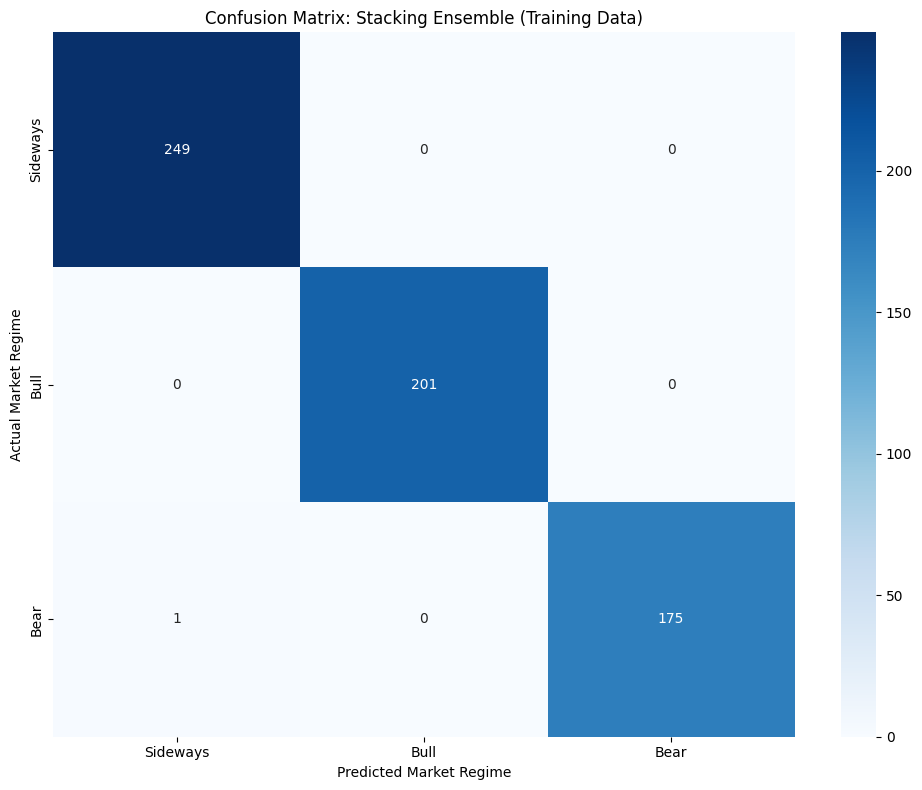

In [ ]:
print("="*60)
print("PART 3: STACKING ENSEMBLE CONFUSION MATRIX")
print("="*60)

# 1. GENERATE THE CONFUSION MATRIX
target_names = ['Sideways', 'Bull', 'Bear']
cm = confusion_matrix(df_labels_train, y_train_pred_stack)

# 2. PLOT THE MATRIX
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=target_names,
            yticklabels=target_names)

plt.title('Confusion Matrix: Stacking Ensemble (Training Data)')
plt.ylabel('Actual Market Regime')
plt.xlabel('Predicted Market Regime')
plt.tight_layout()
plt.show()

## Meta-Learner: Majority Voter

In [ ]:
print("="*60)
print("TRAINING MAJORITY VOTE ENSEMBLE (5-MODEL SOFT VOTING)")
print("="*60)

# --- 1. EXTRACT PROBABILITIES FROM ALL 5 BASE MODELS ---
print("Extracting training probabilities...")
start_time = time.time()

# 1. XGBoost
prob_xgb = xgb_model.predict_proba(X_train_final)

# 2. Logistic Regression (New Base Learner)
prob_lr = final_lr_model.predict_proba(X_train_final)

# 3. SVM
prob_svm = svm_model.predict_proba(X_train_final)

# 4. Random Forest
prob_rf = rf_model.predict_proba(X_train_final)

# 5. Neural Network (DNN)
# verbose=0 keeps the output clean
prob_dnn = dnn_model.predict(X_train_final, verbose=0)

# --- 2. PERFORM SOFT VOTING (AVERAGING) ---
# We average the 3-class probability arrays from all 5 models
# (3 probabilities per model * 5 models) / 5
avg_probabilities = (prob_xgb + prob_lr + prob_svm + prob_rf + prob_dnn) / 5

# The final prediction is the class (0, 1, or 2) with the highest average probability
y_vote_pred = np.argmax(avg_probabilities, axis=1)

duration = time.time() - start_time
print(f"Soft Voting ensemble calculation completed in {duration:.2f} seconds.")
print(f"Ensemble contains: XGBoost, LogReg, SVM, Random Forest, and DNN.")

TRAINING MAJORITY VOTE ENSEMBLE (5-MODEL SOFT VOTING)
Extracting training probabilities...
Soft Voting ensemble calculation completed in 0.51 seconds.
Ensemble contains: XGBoost, LogReg, SVM, Random Forest, and DNN.


In [ ]:
print("\n" + "="*60)
print("VOTING ENSEMBLE: TRAINING PERFORMANCE")
print("="*60)

vote_acc = accuracy_score(df_labels_train, y_vote_pred)
vote_f1 = f1_score(df_labels_train, y_vote_pred, average='macro')

print(f"Voting Accuracy: {vote_acc:.4f}")
print(f"Voting F1-Macro: {vote_f1:.4f}")
print("-" * 30)

# Prediction Distribution Check
target_names = ['Sideways', 'Bull', 'Bear']
vote_counts = pd.Series(y_vote_pred).value_counts().sort_index()

print("\nEnsemble Prediction Distribution:")
for cls in [0, 1, 2]:
    name = target_names[cls]
    count = vote_counts.get(cls, 0)
    print(f"  {name:8}: {count} samples ({count/len(y_vote_pred)*100:.1f}%)")

print("\nDetailed Classification Report:")
print(classification_report(df_labels_train, y_vote_pred, target_names=target_names))


VOTING ENSEMBLE: TRAINING PERFORMANCE
Voting Accuracy: 0.9920
Voting F1-Macro: 0.9919
------------------------------

Ensemble Prediction Distribution:
  Sideways: 253 samples (40.4%)
  Bull    : 201 samples (32.1%)
  Bear    : 172 samples (27.5%)

Detailed Classification Report:
              precision    recall  f1-score   support

    Sideways       0.98      1.00      0.99       249
        Bull       1.00      1.00      1.00       201
        Bear       1.00      0.98      0.99       176

    accuracy                           0.99       626
   macro avg       0.99      0.99      0.99       626
weighted avg       0.99      0.99      0.99       626



MAJORITY VOTE ENSEMBLE: CONFUSION MATRIX


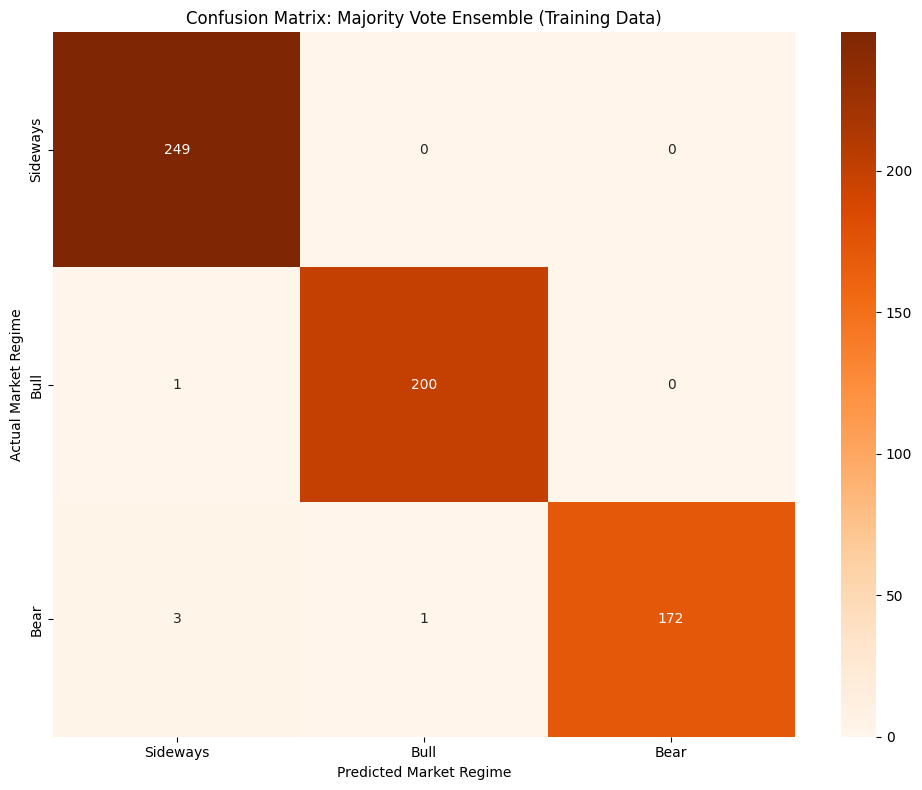

In [ ]:
print("="*60)
print("MAJORITY VOTE ENSEMBLE: CONFUSION MATRIX")
print("="*60)

# --- 1. GENERATE THE CONFUSION MATRIX ---
# y_vote_pred was calculated by averaging probabilities from XGB, SVM, RF, and DNN
target_names = ['Sideways', 'Bull', 'Bear']
cm_vote = confusion_matrix(df_labels_train, y_vote_pred)

# --- 2. PLOT THE MATRIX ---
plt.figure(figsize=(10, 8))
sns.heatmap(cm_vote, annot=True, fmt='d', cmap='Oranges',
            xticklabels=target_names,
            yticklabels=target_names)

plt.title('Confusion Matrix: Majority Vote Ensemble (Training Data)')
plt.ylabel('Actual Market Regime')
plt.xlabel('Predicted Market Regime')
plt.tight_layout()
plt.show()

# Performance Evaluation of all models

In [ ]:
# 1. PREPARE THE DATA
# Using the specific variables we assigned during the training blocks
summary_data = {
    'Model Name': [
        'Logistic Regression',
        'SVM (Poly Kernel)',
        'XGBoost',
        'Random Forest',
        'Deep Neural Network',
        'Voting Ensemble (Soft)',
        'Stacking Meta-Learner'
    ],
    'Accuracy': [
        lr_train_accuracy,
        svm_train_accuracy,
        xgb_train_accuracy,
        rf_train_accuracy,
        dnn_train_accuracy,
        vote_acc,
        stack_train_accuracy
    ],
    'F1-Score (Macro)': [
        lr_train_f1,
        svm_train_f1,
        xgb_train_f1,
        rf_train_f1,
        dnn_train_f1,
        vote_f1,
        stack_train_f1
    ]
}

# 2. CREATE AND DISPLAY THE DATAFRAME
df_final_summary = pd.DataFrame(summary_data)

print("="*60)
print("FINAL MODEL PERFORMANCE SUMMARY (TRAINING SET)")
print("="*60)
df_final_summary.round(4)

FINAL MODEL PERFORMANCE SUMMARY (TRAINING SET)


,Model Name,Accuracy,F1-Score (Macro)
0,Logistic Regression,0.5607,0.5563
1,SVM (Poly Kernel),0.7300,0.7237
2,XGBoost,0.9984,0.9984
3,Random Forest,0.9728,0.9727
4,Deep Neural Network,0.9920,0.9920
5,Voting Ensemble (Soft),0.9920,0.9919
6,Stacking Meta-Learner,0.9984,0.9984


# Prediction for data

In [ ]:
# 1. GENERATE TRAINING META-FEATURES
# Each of the 5 models provides 3 probabilities (Sideways, Bull, Bear)
train_probs_xgb = xgb_model.predict_proba(X_train_final)
train_probs_lr  = final_lr_model.predict_proba(X_train_final)
train_probs_svm = svm_model.predict_proba(X_train_final)
train_probs_rf  = rf_model.predict_proba(X_train_final)
train_probs_dnn = dnn_model.predict(X_train_final, verbose=0)

# Horizontal stack for the Meta-Learner
X_meta_train = np.hstack([
    train_probs_xgb,
    train_probs_lr,
    train_probs_svm,
    train_probs_rf,
    train_probs_dnn
])

# 2. GENERATE STACKING RESULTS
y_train_pred_stack = meta_learner.predict(X_meta_train)
y_train_proba_stack = meta_learner.predict_proba(X_meta_train)

df_results_train_stack = pd.DataFrame({
    'Actual_Regime': df_labels_train,
    'Predicted_Regime': y_train_pred_stack,
    'Conf_Sideways': y_train_proba_stack[:, 0],
    'Conf_Bull': y_train_proba_stack[:, 1],
    'Conf_Bear': y_train_proba_stack[:, 2]
}, index=X_train_final.index)

# 3. GENERATE VOTING RESULTS
# Average the probabilities across all 5 models
avg_probs_vote = (train_probs_xgb + train_probs_lr + train_probs_svm + train_probs_rf + train_probs_dnn) / 5
y_train_pred_vote = np.argmax(avg_probs_vote, axis=1)

df_results_train_vote = pd.DataFrame({
    'Actual_Regime': df_labels_train,
    'Predicted_Regime': y_train_pred_vote,
    'Conf_Sideways': avg_probs_vote[:, 0],
    'Conf_Bull': avg_probs_vote[:, 1],
    'Conf_Bear': avg_probs_vote[:, 2]
}, index=X_train_final.index)

print(f"Training containers created: Stacking ({df_results_train_stack.shape}) and Voting ({df_results_train_vote.shape})")

Training containers created: Stacking ((626, 5)) and Voting ((626, 5))


In [ ]:
import numpy as np
import pandas as pd

# 1. GENERATE TESTING META-FEATURES
# Extracting probabilities from all 5 base models for the test set (X_test_final)
test_probs_xgb = xgb_model.predict_proba(X_test_final)
test_probs_lr  = final_lr_model.predict_proba(X_test_final)
test_probs_svm = svm_model.predict_proba(X_test_final)
test_probs_rf  = rf_model.predict_proba(X_test_final)
test_probs_dnn = dnn_model.predict(X_test_final, verbose=0)

# Create the 15-column input matrix for the meta-learner
X_meta_test = np.hstack([
    test_probs_xgb,
    test_probs_lr,
    test_probs_svm,
    test_probs_rf,
    test_probs_dnn
])

# 2. GENERATE STACKING RESULTS
# Use the trained meta-learner to predict the unlabeled test data
y_test_pred_stack = meta_learner.predict(X_meta_test)
y_test_proba_stack = meta_learner.predict_proba(X_meta_test)

df_results_test_stack = pd.DataFrame({
    'Predicted_Regime': y_test_pred_stack,
    'Conf_Sideways': y_test_proba_stack[:, 0],
    'Conf_Bull': y_test_proba_stack[:, 1],
    'Conf_Bear': y_test_proba_stack[:, 2]
}, index=df_features_test.index)

# 3. GENERATE VOTING RESULTS
# Average the probabilities across all 5 models (Soft Voting)
avg_probs_vote_test = (test_probs_xgb + test_probs_lr + test_probs_svm + test_probs_rf + test_probs_dnn) / 5
y_test_pred_vote = np.argmax(avg_probs_vote_test, axis=1)

df_results_test_vote = pd.DataFrame({
    'Predicted_Regime': y_test_pred_vote,
    'Conf_Sideways': avg_probs_vote_test[:, 0],
    'Conf_Bull': avg_probs_vote_test[:, 1],
    'Conf_Bear': avg_probs_vote_test[:, 2]
}, index=df_features_test.index)

print(f"Testing containers created: Stacking and Voting ({df_results_test_stack.shape[0]} samples).")

Testing containers created: Stacking and Voting (157 samples).


# Export prediction results

In [ ]:
if True: # set as True to export
    # Define File Names
    train_stack_file = 'stack_regime_preds_train.csv'
    train_vote_file  = 'vote_regime_preds_train.csv'
    test_stack_file  = 'stack_regime_preds_test.csv'
    test_vote_file   = 'vote_regime_preds_test.csv'

    # Export Training results (removing Actual_Regime as requested)
    df_results_train_stack.drop(columns=['Actual_Regime']).to_csv(train_stack_file, index=True)
    df_results_train_vote.drop(columns=['Actual_Regime']).to_csv(train_vote_file, index=True)

    # Export Testing results
    df_results_test_stack.to_csv(test_stack_file, index=True)
    df_results_test_vote.to_csv(test_vote_file, index=True)